In [1]:
%matplotlib inline
import os
import tqdm
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import glob
import json 
import plotnine as pn
import matplotlib.pyplot as plt
import collections
from tcre.env import *
from tcre.supervision import get_candidate_classes, SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_MAP
from tcre.exec.v1 import optim
from snorkel import SnorkelSession
from snorkel.models import Candidate
import logging
session = SnorkelSession()
%run ../src/tcre/logging.py
classes = get_candidate_classes()

/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
output_dir = osp.join(RESULTS_DATA_DIR, 'gridsearch-dev', 'run1')
output_dir

'/lab/data/results/gridsearch-dev/run1'

In [3]:
tasks = [classes[c].field for c in classes]
tasks

['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor']

### Initialize Optimizers

In [4]:
from skopt.space import Categorical
from skopt.space import Space

space = Space([
    Categorical(['mult_01', 'sngl_01', 'doub_01'], name='marker_list'),
    Categorical([True, False], name='use_secondary'),
    Categorical([True, False], name='use_swaps'),
    Categorical([True, False], name='use_positions'),
    Categorical(['w2v_frozen', 'w2v_trained', 'denovo'], name='wrd_embedding_type'),
    Categorical(['S', 'L', 'XL'], name='model_size'),
    Categorical([0.0, .001, .005], name='weight_decay'),
    Categorical([.001, .005, .01], name='learning_rate'),
    Categorical([0.0, 0.5, 0.75], name='dropout'),
    Categorical(['LSTM', 'GRU'], name='cell_type'),
    Categorical([True, False], name='bidirectional')
])

In [5]:
space.rvs()[0]

['sngl_01',
 False,
 True,
 False,
 'w2v_trained',
 'L',
 0.0,
 0.001,
 0.5,
 'GRU',
 True]

In [6]:
from skopt import forest_minimize
optimizers = {task: optim.TaskParameterOptimizer(task, space, output_dir, minimizer=forest_minimize) for task in tasks}

### Create Splits for Tasks

In [7]:
cands = session.query(Candidate).filter(Candidate.split.in_([SPLIT_DEV, SPLIT_VAL, SPLIT_TEST])).all()
len(cands)

2368

In [8]:
# Train on dev, use val for validation, and make test predictions
TARGET_MAP = {'dev': 'train', 'val': 'val', 'test': 'test'}
df = pd.DataFrame([
    dict(id=c.id, type=c.type, split=TARGET_MAP[SPLIT_MAP[c.split]])
    for c in cands
])
df.head()

,id,split,type
0,30167,train,inducing_cytokine
1,30168,train,inducing_cytokine
2,30169,train,inducing_cytokine
3,30170,train,inducing_cytokine
4,30171,train,inducing_cytokine


In [9]:
df.groupby(['type', 'split']).size()

type                           split
inducing_cytokine              test     100
                               train    673
                               val       97
inducing_transcription_factor  test     100
                               train    410
                               val      117
secreted_cytokine              test     100
                               train    673
                               val       98
dtype: int64

In [10]:
for task in tasks:
    dft = df.set_index('type').loc[task]
    splits = dft.groupby('split')['id'].unique().apply(list)
    splits_file = optimizers[task].write_splits(splits)
    print(f'Splits written to {splits_file}')

Splits written to /lab/data/results/gridsearch-dev/run1/inducing_cytokine/splits/hopt_inducing_cytokine.json
Splits written to /lab/data/results/gridsearch-dev/run1/secreted_cytokine/splits/hopt_secreted_cytokine.json
Splits written to /lab/data/results/gridsearch-dev/run1/inducing_transcription_factor/splits/hopt_inducing_transcription_factor.json


### Run Search

In [11]:
# Show an example command to be run 
print(optimizers[tasks[0]].get_cmd(space.rvs()[0]))

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py \
--relation-class=inducing_cytokine --device=cuda:1 --output-dir=/lab/data/results/gridsearch-dev/run1/inducing_cytokine/data \
train \
--splits-file=/lab/data/results/gridsearch-dev/run1/inducing_cytokine/splits/hopt_inducing_cytokine.json --save-keys="history" --use-checkpoints=False \
--marker-list=sngl_01 --use-secondary=False --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_trained --model-size=XL --weight-decay=0.005 --learning-rate=0.01 --dropout=0.5 --cell-type=GRU --bidirectional=False > /lab/data/results/gridsearch-dev/run1/inducing_cytokine/log/log.txt 2>&1



In [12]:
# For 3 tasks at about about 30s per iteration, show common time estimations:
time_per_iter_sec = 30
n_iter = np.array([10, 100, 250, 500, 1000])
for n in n_iter:
    time = n * time_per_iter_sec * len(tasks) / 3600
    print(f'Iterations = {n} --> Time = {time} (hrs)')

Iterations = 10 --> Time = 0.25 (hrs)
Iterations = 100 --> Time = 2.5 (hrs)
Iterations = 250 --> Time = 6.25 (hrs)
Iterations = 500 --> Time = 12.5 (hrs)
Iterations = 1000 --> Time = 25.0 (hrs)


In [13]:
results = {}

for task in tasks:
    optimizer = optimizers[task]
    logging.info(f'Running optimization for task {task}')
    # kappa=3.090 -> 99.8% confidence interval (favors exploration when higher than default 1.96)
    res, scores, callbacks = optimizer.run(n_iterations=250, progress_interval=1, checkpoint_interval=10, n_random_starts=10, kappa=3.090)
    
    # Save scores for non-objective (i.e. validation)
    scores_file = osp.join(optimizer.output_dir, 'scores.json')
    pd.DataFrame(scores).to_json(scores_file)
    logging.info(f'Saved scores to {scores_file}')
    
    # Checkpoint final result since it is not saved at every step
    callbacks['saver'](res)
    logging.info(f'Saved final result')
    
    results[task] = res, scores, callbacks

2019-07-07 02:30:05,540:INFO:root: Running optimization for task inducing_cytokine
2019-07-07 02:30:05,541:INFO:tcre.exec.v1.optim: Beginning parameter search with max iterations 250
2019-07-07 02:30:31,712:INFO:tcre.exec.v1.optim: Completed iteration 1 of 250 (score = -0.12121212121212101)
2019-07-07 02:31:00,787:INFO:tcre.exec.v1.optim: Completed iteration 2 of 250 (score = -0.432432432432432)
2019-07-07 02:31:28,855:INFO:tcre.exec.v1.optim: Completed iteration 3 of 250 (score = -0.2)
2019-07-07 02:31:48,454:INFO:tcre.exec.v1.optim: Completed iteration 4 of 250 (score = -0.11111111111111101)
2019-07-07 02:32:05,752:INFO:tcre.exec.v1.optim: Completed iteration 5 of 250 (score = -0.0)
2019-07-07 02:32:38,400:INFO:tcre.exec.v1.optim: Completed iteration 6 of 250 (score = -0.36363636363636304)
2019-07-07 02:33:06,361:INFO:tcre.exec.v1.optim: Completed iteration 7 of 250 (score = -0.21428571428571402)
2019-07-07 02:33:42,105:INFO:tcre.exec.v1.optim: Completed iteration 8 of 250 (score = -

ValueError: Return code 256 (!=0) for command: python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py \
--relation-class=inducing_transcription_factor --device=cuda:1 --output-dir=/lab/data/results/gridsearch-dev/run1/inducing_transcription_factor/data \
train \
--splits-file=/lab/data/results/gridsearch-dev/run1/inducing_transcription_factor/splits/hopt_inducing_transcription_factor.json --save-keys="history" --use-checkpoints=False \
--marker-list=doub_01 --use-secondary=False --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_frozen --model-size=S --weight-decay=0.005 --learning-rate=0.01 --dropout=0.5 --cell-type=LSTM --bidirectional=True > /lab/data/results/gridsearch-dev/run1/inducing_transcription_factor/log/log.txt 2>&1


In [27]:
print(tasks[1])
res, scores, callbacks = gsres[tasks[1]]

secreted_cytokine


In [23]:
res.func_vals[:5]

array([-0.21428571, -0.17391304, -0.        , -0.12903226, -0.16666667])

In [24]:
pd.DataFrame(res.x_iters[:5], columns=[dim.name for dim in space])

,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional
0,sngl_01,True,False,False,denovo,XL,0.000,0.005,0.75,GRU,True
1,mult_01,False,False,True,denovo,XL,0.005,0.010,0.50,GRU,True
2,sngl_01,False,False,False,w2v_frozen,XL,0.005,0.005,0.00,GRU,False
3,mult_01,False,False,False,w2v_trained,S,0.005,0.001,0.75,LSTM,False
4,sngl_01,True,True,False,denovo,XL,0.005,0.001,0.00,LSTM,False


In [25]:
res.models[:5]

[ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                     max_features='auto', max_leaf_nodes=None,
                     min_samples_leaf=3, min_samples_split=2, min_variance=0.0,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                     oob_score=False, random_state=238102835, verbose=0,
                     warm_start=False),
 ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                     max_features='auto', max_leaf_nodes=None,
                     min_samples_leaf=3, min_samples_split=2, min_variance=0.0,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                     oob_score=False, random_state=238102835, verbose=0,
                     warm_start=False),
 ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                     max_features='auto', max_leaf_nodes=None,
                     min_samples_leaf=3, min_samples_s

In [28]:
pd.DataFrame(scores).sort_values('Validation').tail()

,Test,Training,Validation
207,0.358974,0.896552,0.486486
190,0.358974,0.896552,0.486486
204,0.333333,0.736318,0.487805
213,0.250000,0.840909,0.514286
186,0.193548,0.911392,0.533333


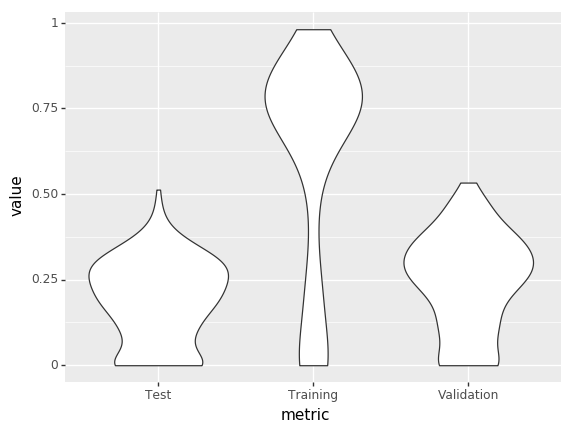

<ggplot: (8775034643555)>

In [26]:
(
    pn.ggplot(
        pd.DataFrame(scores).rename_axis('metric', axis='columns').stack().rename('value').reset_index(),
        pn.aes(x='metric', y='value')
    ) + 
    pn.geom_violin()
)

## Analysis

In [14]:
output_dir

'/lab/data/results/gridsearch-dev/run1'

In [15]:
!ls $output_dir

inducing_cytokine  inducing_transcription_factor  secreted_cytokine


In [47]:
import skopt
# Restore from serialized data

results = {}
for task in tasks:
    optimizer = optimizers[task]
    res = skopt.load(optimizer.get_checkpoints_file())
    
    scores = None
    scores_file = osp.join(optimizer.output_dir, 'scores.json')
    if osp.exists(scores_file):
        scores = pd.read_json(scores_file)
        
    # Not necessary yet
    callbacks = []
    
    results[task] = res, scores, callbacks

In [48]:
#res, scores = results[tasks[1]][0], results[tasks[1]][1]

In [49]:
def get_dfx(results):
    df = []
    for k in results:
        res = results[k][0]
        dfx = pd.DataFrame(res.x_iters, columns=[dim.name for dim in space])
        dfx['score'] = -res.func_vals
        dfx['task'] = k
        dfx['iteration'] = np.arange(len(dfx))
        df.append(dfx)
    return pd.concat(df)

In [68]:
dfx = get_dfx(results)
props = dfx.drop(['score', 'task', 'iteration'], axis=1).columns.tolist()
print(props)
dfx.head()

['marker_list', 'use_secondary', 'use_swaps', 'use_positions', 'wrd_embedding_type', 'model_size', 'weight_decay', 'learning_rate', 'dropout', 'cell_type', 'bidirectional']


,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional,score,task,iteration
0,sngl_01,True,False,False,denovo,XL,0.000,0.005,0.75,GRU,True,0.121212,inducing_cytokine,0
1,mult_01,False,False,True,denovo,XL,0.005,0.010,0.50,GRU,True,0.432432,inducing_cytokine,1
2,sngl_01,False,False,False,w2v_frozen,XL,0.005,0.005,0.00,GRU,False,0.200000,inducing_cytokine,2
3,mult_01,False,False,False,w2v_trained,S,0.005,0.001,0.75,LSTM,False,0.111111,inducing_cytokine,3
4,sngl_01,True,True,False,denovo,XL,0.005,0.001,0.00,LSTM,False,0.000000,inducing_cytokine,4


In [154]:
# Show top configs by task
dfx.groupby('task').apply(lambda g: g.sort_values('score').iloc[-8:])

marker_list  use_secondary  use_swaps  \
task                                                                      
inducing_cytokine             187     sngl_01           True       True   
                              150     sngl_01           True       True   
                              93      sngl_01           True       True   
                              188     sngl_01           True       True   
                              40      sngl_01           True       True   
                              108     sngl_01           True       True   
                              152     sngl_01           True       True   
                              147     sngl_01           True       True   
inducing_transcription_factor 134     mult_01          False      False   
                              131     mult_01          False      False   
                              96      sngl_01          False       True   
                              139     doub_01           True       True   
                              176     doub_01           True       True   
                              178     doub_01           True      False   
                              147     doub_01           True      False   
                              136     doub_01           True      False   
secreted_cytokine             208     sngl_01          False       True   
                              205     doub_01          False       True   
                              197     mult_01          False       True   
                              207     sngl_01          False       True   
                              190     sngl_01          False       True   
                              204     mult_01          False       True   
                              213     doub_01          False      False   
                              186     mult_01          False       True   

                                   use_positions wrd_embedding_type  \
task                                                                  
inducing_cytokine             187           True             denovo   
                              150           True             denovo   
                              93            True             denovo   
                              188           True             denovo   
                              40            True             denovo   
                              108           True             denovo   
                              152           True             denovo   
                              147           True             denovo   
inducing_transcription_factor 134          False        w2v_trained   
                              131          False        w2v_trained   
                              96           False        w2v_trained   
                              139           True         w2v_frozen   
                              176           True         w2v_frozen   
                              178           True         w2v_frozen   
                              147          False         w2v_frozen   
                              136           True         w2v_frozen   
secreted_cytokine             208           True        w2v_trained   
                              205           True        w2v_trained   
                              197           True             denovo   
                              207           True        w2v_trained   
                              190           True        w2v_trained   
                              204           True        w2v_trained   
                              213           True        w2v_trained   
                              186           True             denovo   

                                  model_size  weight_decay  learning_rate  \
task                                                                        
inducing_cytokine             187         XL         0.001          0.010   
     

### Parameter Regression

In [125]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='The default of the `iid` parameter.*')

def get_coefs(est):
    coefs = []
    grps = dfx.groupby(['task'])
    fig, axs = plt.subplots(1, len(grps))
    fig.set_size_inches(18, 4)
    for i, (k, g) in enumerate(grps):
        X = pd.get_dummies(g.drop(['task', 'iteration', 'score'], axis=1).astype(str), prefix_sep=':')
        y = g['score'].values
        est = est.fit(X.values, y)
        y_pred = est.predict(X)
        score = max(r2_score(y, y_pred), 0)
        title = f'{est.__class__.__name__} {k} (R2={score:.2f})'
        pd.DataFrame({'y_true': y, 'y_pred': y_pred}).plot(kind='scatter', x='y_pred', y='y_true', ax=axs[i], title=title)
        coefs.append(
            pd.Series(est.coef_, index=X.columns.to_list()).sort_index()
            .append(pd.Series(dict(task=k, score=score, est=est.__class__.__name__)))
        )
    return est, pd.DataFrame(coefs)

def plot_coefs(est, coefs):
    return (
        pn.ggplot(
            coefs
                .set_index('task').rename_axis('metric', axis='columns').stack().rename('value').reset_index()
                .assign(metric=lambda df: pd.Categorical(df['metric'], ordered=True, categories=df.groupby('metric')['value'].mean().sort_values().index)), 
            pn.aes(x='metric', y='value', fill='task', color='task', group='task')
        ) + 
        pn.geom_point() +
        pn.geom_line() + 
        pn.ggtitle(type(est).__name__) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=90, hjust=.5))
    )

In [126]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

bidirectional:False  \
task                          score    est          weight                          
inducing_cytokine             0.395598 RidgeCV      0.355168             0.004800   
                              0.363142 LassoCV      0.326030             0.000000   
                              0.355091 ElasticNetCV 0.318801             0.000000   
inducing_transcription_factor 0.300539 RidgeCV      0.324356            -0.026903   
                              0.315175 LassoCV      0.340152            -0.059783   

                                                              bidirectional:True  \
task                          score    est          weight                         
inducing_cytokine             0.395598 RidgeCV      0.355168       -4.800272e-03   
                              0.363142 LassoCV      0.326030       -0.000000e+00   
                              0.355091 ElasticNetCV 0.318801       -0.000000e+00   
inducing_transcription_factor 0.300539 RidgeCV      0.324356        2.690265e-02   
                              0.315175 LassoCV      0.340152        1.004326e-17   

                                                              cell_type:GRU  \
task                          score    est          weight                    
inducing_cytokine             0.395598 RidgeCV      0.355168      -0.014821   
                              0.363142 LassoCV      0.326030      -0.019131   
                              0.355091 ElasticNetCV 0.318801      -0.010578   
inducing_transcription_factor 0.300539 RidgeCV      0.324356      -0.036537   
                              0.315175 LassoCV      0.340152      -0.085208   

                                                              cell_type:LSTM  \
task                          score    est          weight                     
inducing_cytokine             0.395598 RidgeCV      0.355168        0.014821   
                              0.363142 LassoCV      0.326030        0.000000   
                              0.355091 ElasticNetCV 0.318801        0.010564   
inducing_transcription_factor 0.300539 RidgeCV      0.324356        0.036537   
                              0.315175 LassoCV      0.340152        0.000000   

                                                              dropout:0.0  \
task                          score    est          weight                  
inducing_cytokine             0.395598 RidgeCV      0.355168     0.004938   
                              0.363142 LassoCV      0.326030     0.000000   
                              0.355091 ElasticNetCV 0.318801     0.000000   
inducing_transcription_factor 0.300539 RidgeCV      0.324356     0.003558   
                              0.315175 LassoCV      0.340152    -0.000000   

                                                              dropout:0.5  \
task                          score    est          weight                  
inducing_cytokine             0.395598 RidgeCV      0.355168     0.008658   
                              0.363142 LassoCV      0.326030     0.000000   
                              0.355091 ElasticNetCV 0.318801     0.000000   
inducing_transcription_factor 0.300539 RidgeCV      0.324356     0.013432   
                              0.315175 LassoCV      0.340152     0.000000   

                                                              dropout:0.75  \
task                          score    est          weight                   
inducing_cytokine             0.395598 RidgeCV      0.355168     -0.014754   
                              0.363142 LassoCV      0.326030     -0.008003   
                              0.355091 ElasticNetCV 0.318801     -0.007436   
inducing_transcription_factor 0.300539 RidgeCV      0.324356     -0.021979   
                              0.315175 LassoCV      0.340152     -0.041082   

                                                              learning_rate:0.001  \
task                          score    est        

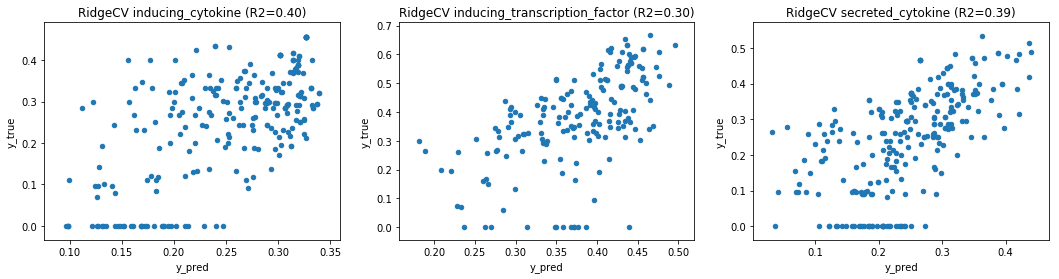

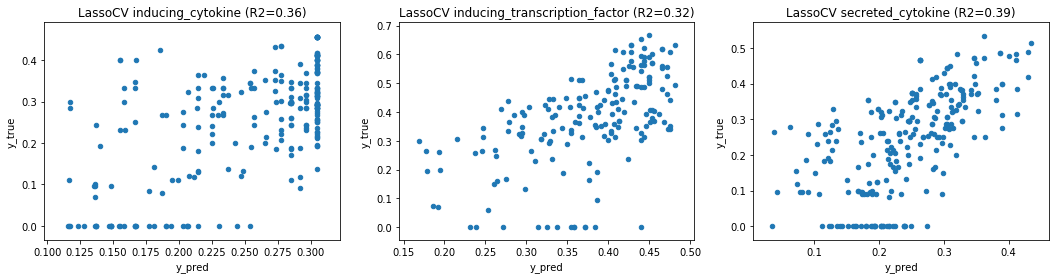

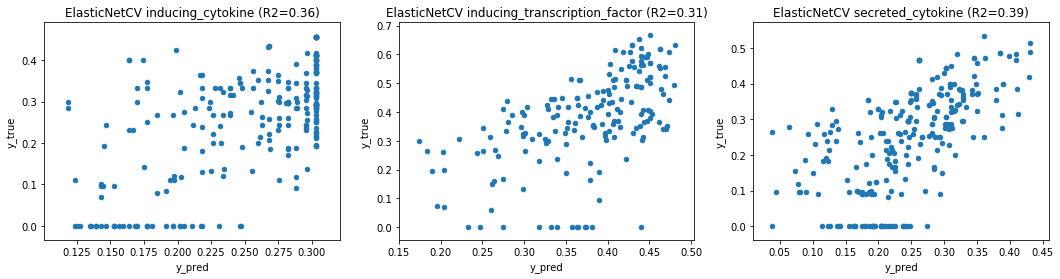

In [138]:
df_coef = pd.concat([
    get_coefs(RidgeCV(normalize=True, cv=5))[1],
    get_coefs(LassoCV(normalize=True, cv=5, random_state=1))[1],
    get_coefs(ElasticNetCV(normalize=True, cv=5, random_state=1))[1]
])

# Add weight for each model as R2 for model / R2 for all models
df_coef = df_coef.groupby('task', group_keys=False).apply(lambda g: g.assign(weight=(g['score'] / g['score'].sum())))
df_coef = df_coef.set_index(['task', 'score', 'est', 'weight'])

df_coef.head()

In [140]:
df_coef_lng = df_coef.rename_axis('parameter', axis='columns').stack().rename('value').reset_index()
df_coef_lng['weighted_value'] = df_coef_lng['value'] * df_coef_lng['weight']
df_coef_lng.head()

,task,score,est,weight,parameter,value,weighted_value
0,inducing_cytokine,0.395598,RidgeCV,0.355168,bidirectional:False,0.004800,0.001705
1,inducing_cytokine,0.395598,RidgeCV,0.355168,bidirectional:True,-0.004800,-0.001705
2,inducing_cytokine,0.395598,RidgeCV,0.355168,cell_type:GRU,-0.014821,-0.005264
3,inducing_cytokine,0.395598,RidgeCV,0.355168,cell_type:LSTM,0.014821,0.005264
4,inducing_cytokine,0.395598,RidgeCV,0.355168,dropout:0.0,0.004938,0.001754


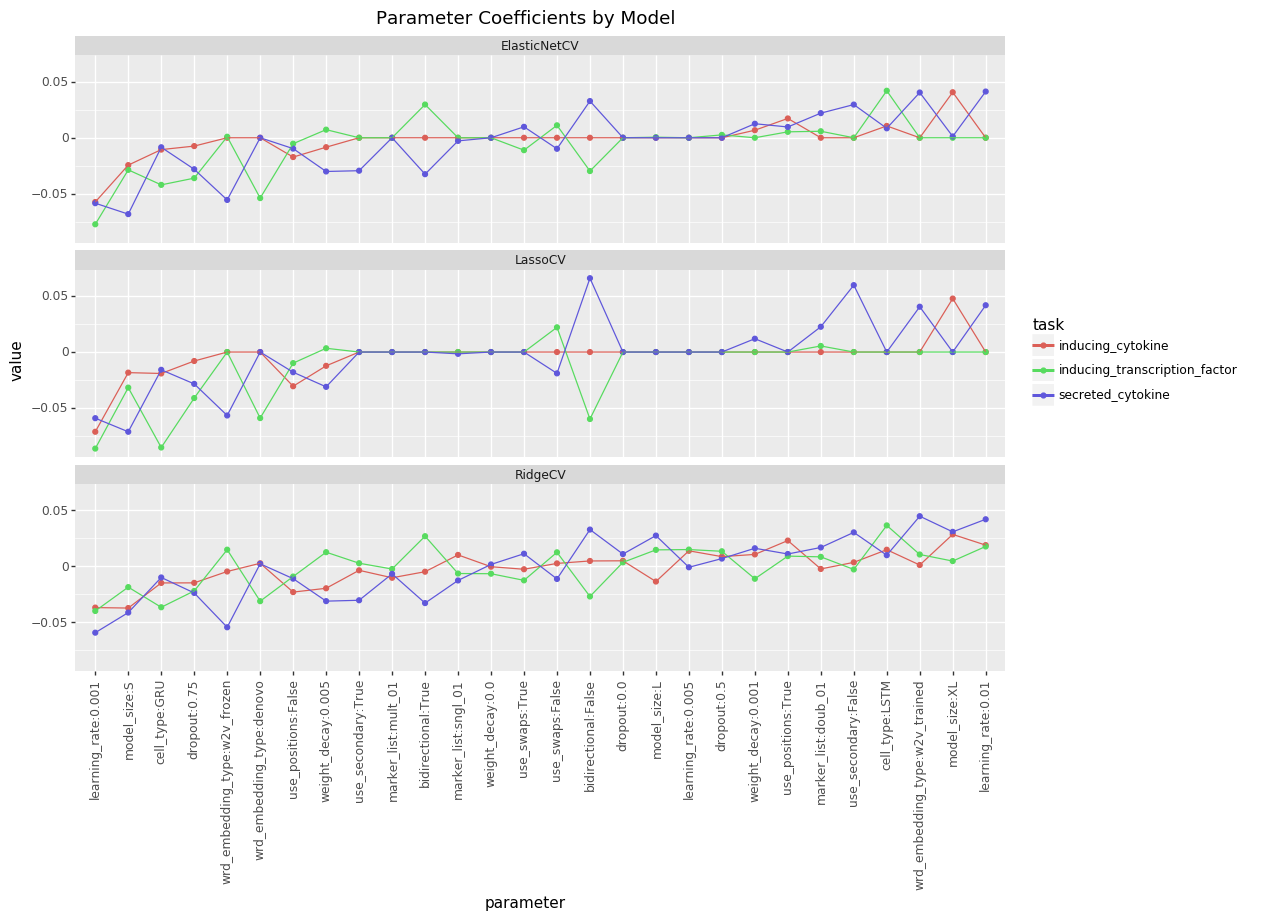

<ggplot: (-9223363295293512567)>

In [141]:
(
    pn.ggplot(
        df_coef_lng.assign(parameter=lambda df: pd.Categorical(
            df['parameter'], ordered=True, 
            categories=df.groupby('parameter')['weighted_value'].mean().sort_values().index
        )), 
        pn.aes(x='parameter', y='value', fill='task', color='task', group='task')
    ) + 
    pn.geom_point() +
    pn.geom_line() + 
    pn.ggtitle('Parameter Coefficients by Model') + 
    pn.facet_wrap('~ est', ncol=1) +
    pn.theme(figure_size=(12, 8), axis_text_x=pn.element_text(rotation=90, hjust=.5))
)

### Score Distributions

In [37]:
# TODO: Add more diagnostic visualizations:
# - Score (not just f1) distribution by task
# - Score (not just f1) tables by task
# - Label balance?
# dfp.groupby('relation_class')[['precision', 'recall', 'f1']].agg(['mean', 'median']).round(2).style.background_gradient()

# scores = dfp.groupby('relation_class')\
#     .apply(lambda g: g.set_index('config_id').sort_values('f1').tail(1)[['precision', 'recall', 'f1']])\
#     .round(2).style.background_gradient()
# scores

# Configs @ max F1
# dfp.set_index(['relation_class', 'config_id']).loc[scores.index].drop(['accuracy', 'recall', 'label'], 1).stack()

# Show config choices over iterations
# (
#     pn.ggplot(
#         pd.get_dummies(dfx.astype(str)).rename_axis('iteration', axis='index').rename_axis('param', axis='columns').stack().rename('value').reset_index(),
#         pn.aes(x='iteration', y='param', fill='value')
#     ) + 
#     pn.geom_tile() + 
#     pn.theme(figure_size=(16, 16))
# )
# #pd.get_dummies(dfx.astype(str)).rename_axis('iteration', axis='index').rename_axis('param', axis='columns').stack().rename('value').reset_index().head()

## Export

Export top model configurations. This is based on the average performance of each parameter as determined by regression.  

Individual max scores are not used to select the top models because the validation set is so small and the search space large enough by comparison that parameter settings that result in poor models on average often end up at the top of the list.

In [152]:
top_config = {}
for k, v in df_coef_lng.groupby('parameter')['weighted_value'].mean().sort_values(ascending=False).items():
    param, val = k.split(':')
    if param not in top_config:
        top_config[param] = val
top_config

{'learning_rate': '0.01',
 'model_size': 'XL',
 'wrd_embedding_type': 'w2v_trained',
 'cell_type': 'LSTM',
 'use_secondary': 'False',
 'marker_list': 'doub_01',
 'use_positions': 'True',
 'weight_decay': '0.001',
 'dropout': '0.5',
 'bidirectional': 'False',
 'use_swaps': 'False'}

In [150]:
# Use frozen and trainable versions of best config for further training
top_models = pd.DataFrame([
    {**dict(top_config), **dict(wrd_embedding_type=v)}
    for v in ['w2v_frozen', 'w2v_trained']
])
top_models

,bidirectional,cell_type,dropout,learning_rate,marker_list,model_size,use_positions,use_secondary,use_swaps,weight_decay,wrd_embedding_type
0,False,LSTM,0.5,0.01,doub_01,XL,True,False,False,0.001,w2v_frozen
1,False,LSTM,0.5,0.01,doub_01,XL,True,False,False,0.001,w2v_trained


In [151]:
path = osp.join(output_dir, 'top_model_configurations.json')
top_models.to_json(path)
path

'/lab/data/results/gridsearch-dev/run1/top_model_configurations.json'

### Old

In [4]:
output_dir = osp.join(RESULTS_DATA_DIR, 'gridsearch-dev', 'run2')

dirs = [f.split('/')[-2] for f in glob.glob(output_dir + '/*/history.json')]
parts = []
for d in dirs:
    with open(osp.join(output_dir, d, 'history.json'), 'r') as f:
        history = json.load(f)
    with open(osp.join(output_dir, d, 'config.json'), 'r') as f:
        config = json.load(f)
    parts.append((d, pd.Series(config), pd.DataFrame(history)))
len(parts)

288

In [5]:
parts[0][1].apply(np.isscalar)

relation_class         True
entity_types          False
marker_list            True
use_secondary          True
use_swaps              True
use_lower              True
use_positions          True
wrd_embedding_type     True
model_size             True
learning_rate          True
weight_decay           True
dropout                True
vocab_limit            True
device                 True
label                  True
markers               False
swaps                 False
model_args            False
dtype: bool

In [6]:
parts[0][2].head()

,accuracy,ct,epoch,f1,loss,lr,precision,recall,type
0,0.802548,471,1,0.0,0.693147,0.005,0.0,0.0,Training
1,0.801980,202,1,0.0,0.693147,0.005,0.0,0.0,Validation
2,0.802548,471,2,0.0,0.693147,0.005,0.0,0.0,Training
3,0.801980,202,2,0.0,0.693147,0.005,0.0,0.0,Validation
4,0.802548,471,3,0.0,0.693147,0.005,0.0,0.0,Training


In [7]:
df = []
for p in parts:
    config_id = int(p[0].split('_')[-1])
    config = p[1]
    history = p[2]
    props = config[config.apply(np.isscalar)].to_dict()
    history = history.assign(**props).assign(config_id=config_id)
    df.append(history)
df = pd.concat(df)
df.head()

,accuracy,ct,epoch,f1,loss,lr,precision,recall,type,relation_class,...,use_positions,wrd_embedding_type,model_size,learning_rate,weight_decay,dropout,vocab_limit,device,label,config_id
0,0.802548,471,1,0.0,0.693147,0.005,0.0,0.0,Training,inducing_cytokine,...,True,w2v_frozen,L,0.005,0.0,0.0,50000,cuda:1,relation_class=inducing_cytokine:marker_list=m...,0
1,0.801980,202,1,0.0,0.693147,0.005,0.0,0.0,Validation,inducing_cytokine,...,True,w2v_frozen,L,0.005,0.0,0.0,50000,cuda:1,relation_class=inducing_cytokine:marker_list=m...,0
2,0.802548,471,2,0.0,0.693147,0.005,0.0,0.0,Training,inducing_cytokine,...,True,w2v_frozen,L,0.005,0.0,0.0,50000,cuda:1,relation_class=inducing_cytokine:marker_list=m...,0
3,0.801980,202,2,0.0,0.693147,0.005,0.0,0.0,Validation,inducing_cytokine,...,True,w2v_frozen,L,0.005,0.0,0.0,50000,cuda:1,relation_class=inducing_cytokine:marker_list=m...,0
4,0.802548,471,3,0.0,0.693147,0.005,0.0,0.0,Training,inducing_cytokine,...,True,w2v_frozen,L,0.005,0.0,0.0,50000,cuda:1,relation_class=inducing_cytokine:marker_list=m...,0


In [8]:
# Assign numeric id for whatever it is that makes an experiment unique
df['exp_id'] = (df.groupby(['relation_class', 'config_id']).cumcount() == 0).astype(int).cumsum()
df['exp_id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33684 entries, 0 to 105
Data columns (total 25 columns):
accuracy              33684 non-null float64
ct                    33684 non-null int64
epoch                 33684 non-null int64
f1                    33684 non-null float64
loss                  33684 non-null float64
lr                    33684 non-null float64
precision             33684 non-null float64
recall                33684 non-null float64
type                  33684 non-null object
relation_class        33684 non-null object
marker_list           33684 non-null object
use_secondary         33684 non-null bool
use_swaps             33684 non-null bool
use_lower             33684 non-null bool
use_positions         33684 non-null bool
wrd_embedding_type    33684 non-null object
model_size            33684 non-null object
learning_rate         33684 non-null float64
weight_decay          33684 non-null float64
dropout               33684 non-null float64
vocab_limit   

In [10]:
cols = ['type', 'exp_id']
dfp = (
    df.sort_values(cols + ['f1'], ascending=False).groupby(cols, group_keys=False).head(1)
    .pipe(lambda df: df[df['type'].isin(['Validation'])])
)
dfp.head()

,accuracy,ct,epoch,f1,loss,lr,precision,recall,type,relation_class,...,wrd_embedding_type,model_size,learning_rate,weight_decay,dropout,vocab_limit,device,label,config_id,exp_id
55,0.658537,123,28,0.487805,0.812874,0.001250,0.357143,0.769231,Validation,inducing_transcription_factor,...,w2v_frozen,L,0.005,0.005,0.0,50000,cuda:1,relation_class=inducing_transcription_factor:m...,10,288
111,0.813008,123,56,0.581818,0.709272,0.000313,0.551724,0.615385,Validation,inducing_transcription_factor,...,w2v_frozen,L,0.005,0.005,0.5,50000,cuda:1,relation_class=inducing_transcription_factor:m...,9,287
89,0.829268,123,45,0.553191,0.693329,0.001250,0.619048,0.500000,Validation,inducing_transcription_factor,...,w2v_frozen,L,0.005,0.005,0.0,50000,cuda:1,relation_class=inducing_transcription_factor:m...,8,286
121,0.829268,123,61,0.588235,0.697235,0.000313,0.600000,0.576923,Validation,inducing_transcription_factor,...,w2v_frozen,L,0.005,0.001,0.5,50000,cuda:1,relation_class=inducing_transcription_factor:m...,7,285
139,0.804878,123,70,0.520000,0.708454,0.000313,0.541667,0.500000,Validation,inducing_transcription_factor,...,w2v_frozen,L,0.005,0.001,0.0,50000,cuda:1,relation_class=inducing_transcription_factor:m...,6,284


## Top Level Stats

In [11]:
dfp.groupby('relation_class')[['precision', 'recall', 'f1']].agg(['mean', 'median']).round(2).style.background_gradient()

In [12]:
scores = dfp.groupby('relation_class')\
    .apply(lambda g: g.set_index('config_id').sort_values('f1').tail(1)[['precision', 'recall', 'f1']])\
    .round(2).style.background_gradient()
scores

,,precision,recall,f1
relation_class,config_id,,,
inducing_cytokine,53,0.66,0.72,0.69
inducing_transcription_factor,80,0.64,0.69,0.67
secreted_cytokine,5,0.95,0.75,0.84


In [13]:
# Configs @ max F1
dfp.set_index(['relation_class', 'config_id']).loc[scores.index].drop(['accuracy', 'recall', 'label'], 1).stack()

relation_class                 config_id                    
inducing_cytokine              53         ct                            202
                                          epoch                          73
                                          f1                       0.690476
                                          loss                     0.684657
                                          lr                      0.0003125
                                          precision                0.659091
                                          type                   Validation
                                          marker_list               doub_01
                                          use_secondary               False
                                          use_swaps                    True
                                          use_lower                   False
                                          use_positions                True
                           

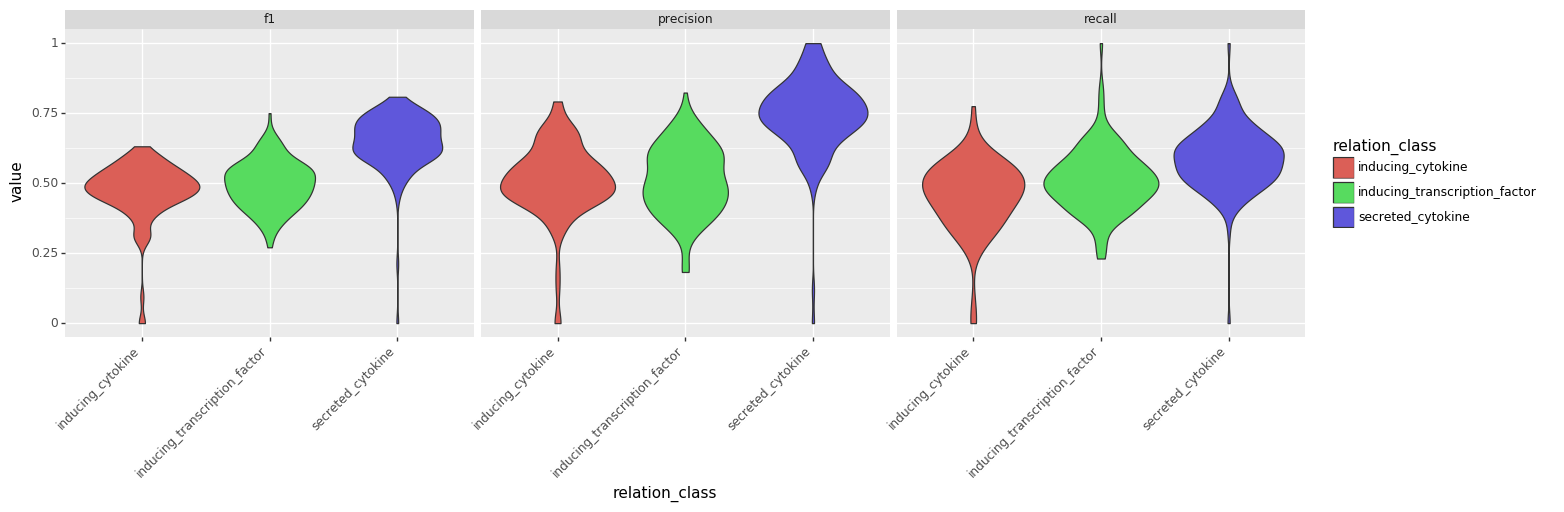

<ggplot: (-9223363305113613743)>

In [198]:
(
    pn.ggplot(
        dfp.set_index('relation_class')[['precision', 'recall', 'f1']].rename_axis('metric', axis=1).stack().rename('value').reset_index(),
        pn.aes(x='relation_class', y='value', fill='relation_class')
    ) + 
    pn.facet_wrap('~metric') + 
    pn.geom_violin() + 
    pn.theme(figure_size=(16, 4), axis_text_x=pn.element_text(rotation=45, hjust=1))
)

In [190]:
# Expected F1 for given class distributions and a random prediction:
from sklearn.metrics import f1_score
res = []
for a in [.05, .1, .15, .2, .25, .3, .4, .5]:
    y_sim = np.random.choice([0, 1], size=1000000, p=[1-a, a])
    y_pre = np.random.choice([0, 1], size=1000000, p=[1-a, a])
    print(a, f1_score(y_pre, y_sim))

0.05 0.05076314527728943
0.1 0.098911849254248
0.15 0.15077381925423772
0.2 0.20044124489091447
0.25 0.24981482000504487
0.3 0.3004187270630527
0.4 0.4013084165741077
0.5 0.49966961794639303
